## 0 Load modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import matplotlib.colors as colors
import cmocean as cmo
import cftime
import nc_time_axis

#matplotlib.use('GTKAgg') 
from numpy import ma
import os
import argparse
import cartopy
import matplotlib as matplotlib
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
import sys
import re
from cartopy.feature import LAND

## 1 Utilities
### 1.1 Natural earth features

In [2]:
# ============================ plot utility ========================================
def add_land_features(ax,cfeature_lst):
# get isf groiunding line, ice shelf front and coastline
    for ifeat,cfeat in enumerate(cfeature_lst):
        if cfeat=='isf':
            #feature = cartopy.feature.NaturalEarthFeature('physical', 'antarctic_ice_shelves_polys', '50m',facecolor='0.75',edgecolor='k') # global plot
            feature = cartopy.feature.NaturalEarthFeature('physical', 'antarctic_ice_shelves_polys', '50m',facecolor='none',edgecolor='k')
        elif cfeat=='lakes':
            feature = cartopy.feature.NaturalEarthFeature('physical', 'lakes'                      , '50m',facecolor='none',edgecolor='k')
        elif cfeat=='coast':
            feature = cartopy.feature.NaturalEarthFeature('physical', 'coastline'                  , '50m',facecolor='0.75',edgecolor='k')
        elif cfeat=='land':
            feature = cartopy.feature.NaturalEarthFeature('physical', 'land'                       , '50m',facecolor='0.75',edgecolor='k')
        elif cfeat=='bathy_z1000':
            feature = cartopy.feature.NaturalEarthFeature('physical', 'bathymetry_J_1000'          , '10m',facecolor='none',edgecolor='k')
        elif cfeat=='bathy_z2000':
            feature = cartopy.feature.NaturalEarthFeature('physical', 'bathymetry_I_2000'          , '10m',facecolor='none',edgecolor='k')
        elif cfeat=='bathy_z3000':
            feature = cartopy.feature.NaturalEarthFeature('physical', 'bathymetry_H_3000'          , '10m',facecolor='none',edgecolor='k')
        else:
            print('feature unknown : '+cfeat)
            sys.exit(42)
        ax.add_feature(feature,linewidth=0.5)

### 1.2 Load bathymetry, lon and lat for the inset

In [3]:

cfile='DATA/OPM026/mesh.nc'
ncid   = nc.Dataset(cfile)
bathy = ncid.variables['bathy_metry'][:,0:-2,:].squeeze()
ncid   = nc.Dataset(cfile)
lon = ncid.variables['nav_lon'][0:-2,:]
lat = ncid.variables['nav_lat'][0:-2,:]
delta_lon=np.abs(np.diff(lon))
j_lst,i_lst=np.nonzero(delta_lon>180)
for idx in range(0,len(j_lst)):
    lon[j_lst[idx], i_lst[idx]+1:] += 360

### 1.3 Box definition for the inset

In [4]:

class box(object):
    def __init__(self,corner,name):
        self.xmin=corner[0]-1
        self.xmax=corner[1]-1
        self.ymin=corner[2]-1
        self.ymax=corner[3]-1
        self.name=name

In [5]:

box_lst=[]
box_lst.append(box([710,741,202,266],'AMU'))
box_lst.append(box([891,938,204,258],'WWED'))
box_lst.append(box([347,404,150,233],'WROSS'))
box_lst.append(box([448,519,152,180],'EROSS'))
box_lst.append(box([968,1020,159,190],'EWED'))

mask=np.zeros(shape=bathy.shape)
for box in box_lst:
    mask[box.ymin:box.ymax,box.xmin:box.xmax] = 1.0

## 2 plot figure
Data loading is made with this bloc

/usr/local/anaconda3/envs/TiPACCs_plot/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'rasterized'
  result = super().contour(*args, **kwargs)


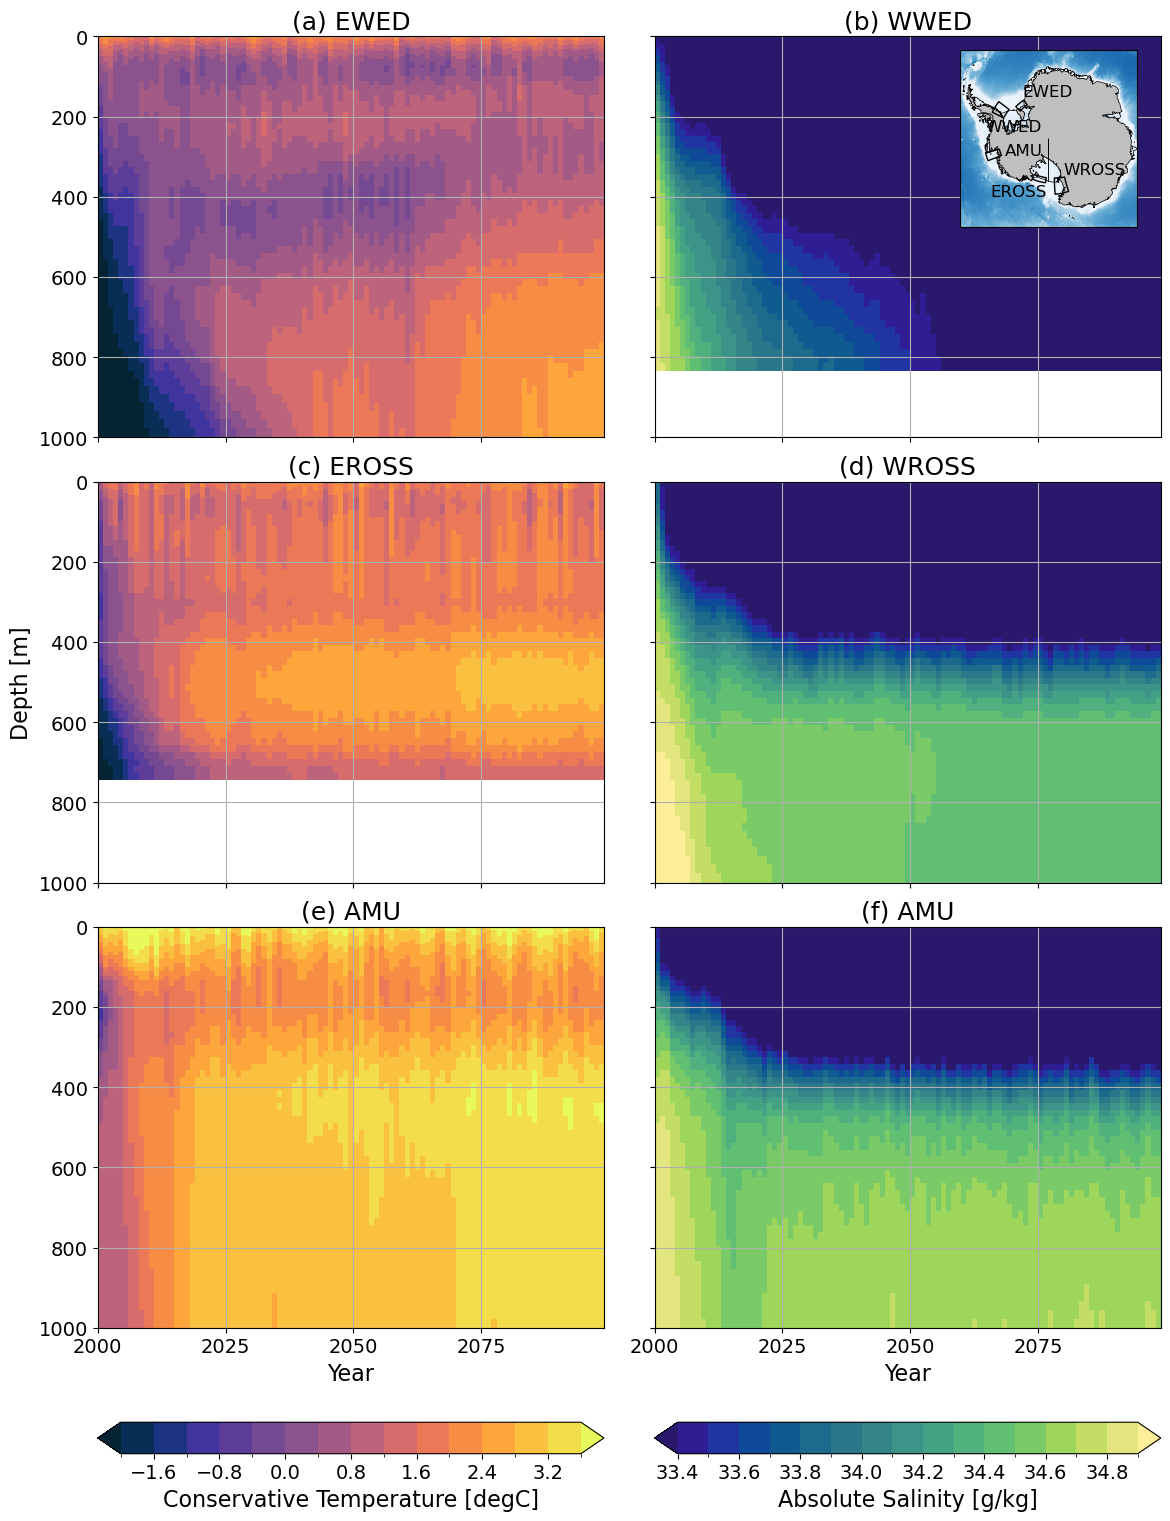

In [6]:
fig=plt.figure(figsize=np.array([300,400]) / 25.4)
gs = fig.add_gridspec(3, 2)
ax=[None]*6

#================================================================================================================================
# temperature

input_dic={'zone':'WROSS','levs':np.linspace(-2, 3.6, 15),'cmap':cmo.cm.thermal,'units':'[degC]','var':['Tprof','mean_votemper']}
czone=input_dic['zone']
rlevspert=input_dic['levs']
cmap=plt.get_cmap(input_dic['cmap'],20)
cunit=input_dic['units']
cvar=input_dic['var']

# EWED box temperature plot
#==========================
czone='EWED'
ax[0] = fig.add_subplot(gs[0,0])
ds_ovm=xr.open_dataset('DATA/{}_{}_eORCA025.L121-OPM031_1y.nc'.format(czone,cvar[0])).squeeze(dim=['x','y'],drop=True)
ds_ovm[cvar[1]].transpose().plot(cmap=cmap,levels=rlevspert,extend='both',add_colorbar=False)
plt.ylabel("",fontsize=16)
plt.ylim([0,1000])
plt.gca().invert_yaxis()
plt.xlabel("",fontsize=16)
plt.title('(a) '+czone,fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax[0].set_xticklabels("")
plt.grid()

# EROSS box temperature plot
#===========================
czone='EROSS'
ax[1] = fig.add_subplot(gs[1,0])
ds_ovm=xr.open_dataset('DATA/{}_{}_eORCA025.L121-OPM031_1y.nc'.format(czone,cvar[0])).squeeze(dim=['x','y'],drop=True)
ds_ovm[cvar[1]].transpose().plot(cmap=cmap,ax=ax[1],levels=rlevspert,extend='both',add_colorbar=False)
plt.ylabel("Depth [m]",fontsize=16)
plt.ylim([0,1000])
plt.gca().invert_yaxis()
plt.xlabel("",fontsize=16)
plt.title('(c) '+czone,fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax[1].set_xticklabels("")
plt.grid()

# AMU box  temperature plot
#==========================
czone='AMU'
ax[2] = fig.add_subplot(gs[2,0])
ds_ovm=xr.open_dataset('DATA/{}_{}_eORCA025.L121-OPM031_1y.nc'.format(czone,cvar[0])).squeeze(dim=['x','y'],drop=True)
hdl=ds_ovm[cvar[1]].transpose().plot(cmap=cmap,ax=ax[2],levels=rlevspert,extend='both',add_colorbar=False)
plt.ylabel("",fontsize=16)
plt.ylim([0,1000])
plt.gca().invert_yaxis()
plt.xlabel("Year",fontsize=16)
plt.title('(e) '+czone,fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()

#================================================================================================================================
# salinity

input_dic={'zone':['WWED','WROSS','AMU'],'levs':np.linspace(33.4, 34.9, 16),'cmap':cmo.cm.haline,'units':'[g/kg]','var':['Sprof','mean_vosaline','Salinity']}
rlevspert=input_dic['levs']
cmap=plt.get_cmap(input_dic['cmap'],20)
cunit2=input_dic['units']
cvar=input_dic['var']

# WWED box salinity plot
#=======================
czone=input_dic['zone'][0]
ax[3] = fig.add_subplot(gs[0,1])
ds_ovm2=xr.open_dataset('DATA/{}_{}_eORCA025.L121-OPM031_1y.nc'.format(czone,cvar[0])).squeeze(dim=['x','y'],drop=True)
ds_ovm2[cvar[1]].transpose().plot(cmap=cmap,levels=rlevspert,extend='both',add_colorbar=False)
plt.ylabel("",fontsize=16)
plt.ylim([0,1000])
plt.gca().invert_yaxis()
plt.xlabel("",fontsize=16)
plt.title('(b) '+czone,fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax[3].set_xticklabels("")
ax[3].set_yticklabels("")
plt.grid()

# WROSS box salinity plot
#========================
czone=input_dic['zone'][1]
ax[4] = fig.add_subplot(gs[1,1])
ds_ovm2=xr.open_dataset('DATA/{}_{}_eORCA025.L121-OPM031_1y.nc'.format(czone,cvar[0])).squeeze(dim=['x','y'],drop=True)
ds_ovm2[cvar[1]].transpose().plot(cmap=cmap,ax=ax[4],levels=rlevspert,extend='both',add_colorbar=False)
plt.ylabel("",fontsize=16)
plt.ylim([0,1000])
plt.gca().invert_yaxis()
plt.xlabel("",fontsize=16)
plt.title('(d) '+czone,fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax[4].set_xticklabels("")
ax[4].set_yticklabels("")
plt.grid()

# AMU box salinity plot
#======================
czone=input_dic['zone'][2]
ax[5] = fig.add_subplot(gs[2,1])
ds_ovm2=xr.open_dataset('DATA/{}_{}_eORCA025.L121-OPM031_1y.nc'.format(czone,cvar[0])).squeeze(dim=['x','y'],drop=True)
hdl2=ds_ovm2[cvar[1]].transpose().plot(cmap=cmap,ax=ax[5],levels=rlevspert,extend='both',add_colorbar=False)
plt.ylabel("",fontsize=16)
plt.ylim([0,1000])
plt.gca().invert_yaxis()
plt.xlabel("Year",fontsize=16)
plt.title('(f) '+czone,fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax[5].set_yticklabels("")
plt.grid()

#====================================================================================================
# adjust white space
fig.subplots_adjust(left=0.08,right=0.98, bottom=0.13, top=0.95, wspace=0.1, hspace=0.11)

#====================================================================================================
# temperature colorbar
x0=1.0; x1=0.0; y0=1.0; y1=0.0
for iplt in range(0,3):
    ax[iplt].apply_aspect()
    zbox=ax[iplt].get_position()
    box=[zbox.x0,zbox.x1,zbox.y0,zbox.y1]
    x0=np.min([x0,box[0]])
    x1=np.max([x1,box[1]])
    y0=np.min([y0,box[2]])
    y1=np.max([y1,box[3]])
boxxy=[x0, y0, x1, y1]

cax  = plt.axes([boxxy[0], boxxy[1]-0.08, boxxy[2]-boxxy[0], 0.02 ])
cbar = plt.colorbar(hdl, cax=cax, orientation='horizontal')
cbar.set_label(label='Conservative Temperature '+cunit, fontsize=16)
cbar.ax.tick_params(labelsize=14)

#====================================================================================================
# salinity colorbar
x0=1.0; x1=0.0; y0=1.0; y1=0.0
for iplt in range(3,6):
    ax[iplt].apply_aspect()
    zbox=ax[iplt].get_position()
    box=[zbox.x0,zbox.x1,zbox.y0,zbox.y1]
    x0=np.min([x0,box[0]])
    x1=np.max([x1,box[1]])
    y0=np.min([y0,box[2]])
    y1=np.max([y1,box[3]])
boxxy=[x0, y0, x1, y1]

cax  = plt.axes([boxxy[0], boxxy[1]-0.08, boxxy[2]-boxxy[0], 0.02 ])
cbar = plt.colorbar(hdl2, cax=cax, orientation='horizontal')
cbar.set_label(label='Absolute Salinity '+cunit2, fontsize=16)
cbar.ax.tick_params(labelsize=14)

#====================================================================================================
# plot map inset
left, bottom, width, height = [0.81, 0.76, 0.15, 0.25]
proj=ccrs.Stereographic(central_latitude=-90.0, central_longitude=0.0)
ax2 = fig.add_axes([left, bottom, width, height],projection=proj)

XY_lim=[-180, 180, -90, -65]

add_land_features(ax2,['isf','lakes','land'])

ax2.pcolormesh(lon,lat,bathy,cmap='Blues',vmin=0,vmax=7000,transform=ccrs.PlateCarree(),rasterized=True)
ax2.contour(lon,lat,mask,levels=[0.99, 2.0],transform=ccrs.PlateCarree(),colors='k',rasterized=True,linewidths=1)

box=box_lst[0]; ax2.text(lon[box.ymin,box.xmin]-1, lat[box.ymin,box.xmin]-1,box.name,transform=ccrs.PlateCarree(),color='k',fontsize=12)
box=box_lst[1]; ax2.text(lon[box.ymin,box.xmin]-18, lat[box.ymin,box.xmin]+4,box.name,transform=ccrs.PlateCarree(),color='k',fontsize=12)
box=box_lst[2]; ax2.text(lon[box.ymin,box.xmin], lat[box.ymin,box.xmin]-1,box.name,transform=ccrs.PlateCarree(),color='k',fontsize=12)
box=box_lst[3]; ax2.text(lon[box.ymin,box.xmin]+42, lat[box.ymin,box.xmin]+12,box.name,transform=ccrs.PlateCarree(),color='k',fontsize=12)
box=box_lst[4]; ax2.text(lon[box.ymax,box.xmax]+1, lat[box.ymax,box.xmax]+1,box.name,transform=ccrs.PlateCarree(),color='k',fontsize=12)

ax2.set_extent(XY_lim, ccrs.PlateCarree())

fig.savefig('fig09.png', format='png', dpi=150)